<a href="https://colab.research.google.com/github/Anvithanm/DCGAN-Fashion-Mnist/blob/main/GAN_For_generating_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



	Deep Convolutional Generative Adversarial Network  |  TensorFlow Core

Note: Reference for Fashion MNIST dataset --> fashion_mnist  |  TensorFlow Datasets


###By : Anvitha Hiriadka
###NUID: 002472965

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-hja7hbvn
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-hja7hbvn
  Resolved https://github.com/tensorflow/docs to commit a81ff2e4ebf518b45cad643d88063c6f2b9e5a1e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.3.6.10029-py3-none-any.whl size=186351 sha256=cb1aff9e222565a18ef231b2fc76b766d6e202988fdcd2592e6a8979a618b8aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-hpbesqa0/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs


In [ ]:
#Importing necessary libararies
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

print(tf.__version__)

2.18.0


Loading and preparing the dataset

In [ ]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [ ]:
train_images.shape

(60000, 28, 28)

In [ ]:
len(train_labels)

60000

In [ ]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [ ]:
test_images.shape

(10000, 28, 28)

In [ ]:
len(test_labels)

10000

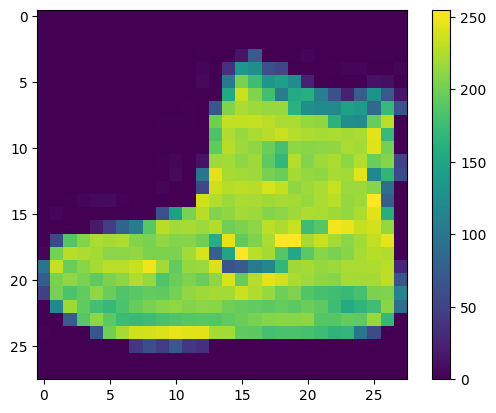

In [ ]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

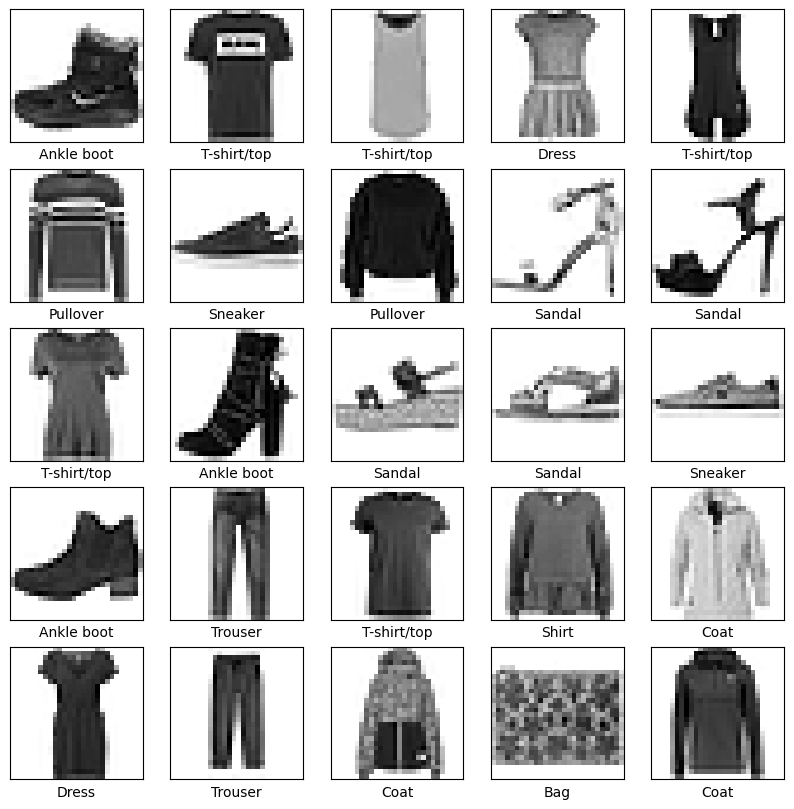

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [ ]:
# Normalize images to [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images[0][0]

array([[-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]], dtype=float32)

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Create batches
#Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

###Creating the models - The Generator and the Discriminator

The Generator model

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Using the above untrained image to generate the image

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


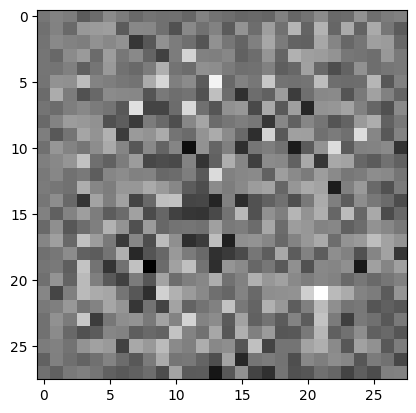

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Creating the Discriminator model - CNN based Image classifier

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0021892]], shape=(1, 1), dtype=float32)


Generator and discriminator loss functions

In [ ]:
# Loss functions for generator and discriminator
def generator_loss(fake_output):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake_output) * 0.9, fake_output)  # Label smoothing

def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_output) * 0.9, real_output)  # Label smoothing
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
# Optimizers
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
#Checkpointing
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Please Note :
2 Trainings are performed :

1) Training1 with Epoch = 150

2) Training2 with Epoch = 200 --> Increased epochs for better convergence


### Training1 with Epoch = 150

In [ ]:
# Training function
EPOCHS = 150
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    # Generate random noise as input for the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    # Record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate images from noise using the generator
        generated_images = generator(noise, training=True)
        # Get discriminator predictions for real images (should ideally be classified as real)
        real_output = discriminator(images, training=True)
        # Get discriminator predictions for generated (fake) images (should ideally be classified as fake)
        fake_output = discriminator(generated_images, training=True)
        # Compute generator loss based on how well it fooled the discriminator
        gen_loss = generator_loss(fake_output)
        # Compute discriminator loss based on its ability to distinguish real from fake images
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients of the generator loss and discriminator loss with respect to its trainable variables
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the computed gradients to update the generator and discriminator weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_show_images(model, epoch, seed):
    generated_images = model(seed, training=False)
    fig, axes = plt.subplots(1, seed.shape[0], figsize=(seed.shape[0]*2, 2))
    for i in range(seed.shape[0]):
        axes[i].imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axes[i].axis('off')
    plt.show()

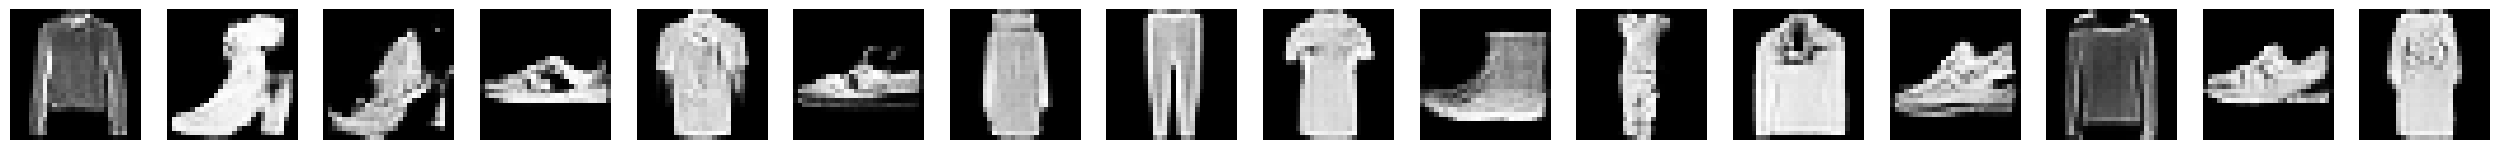

Time for epoch 150 is 17.568594694137573 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
#Redifing thre function to increase the figure for displaying the final results - Generator model generating 3 images of clothing
# Generate and display images
def generate_and_show_images(model, num_images):
    noise = tf.random.normal([num_images, noise_dim])
    generated_images = model(noise, training=False)
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        axes[i].imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axes[i].axis('off')
    plt.show()

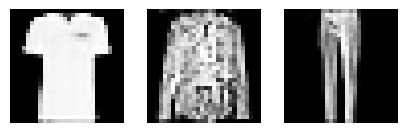

In [ ]:
# Generate 3 different clothing items
generate_and_show_images(generator, 3)

**The above results are the images generated after 150 epochs of training.**

Generated 3 images of different clothing.

### Training2 with Epoch = 200

In [ ]:
# Training function
EPOCHS = 200  # Increased epochs for better convergence
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5, 5))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

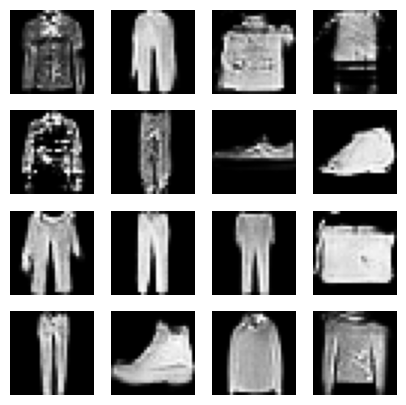

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
#Function - Generator model generating 3 images of clothing
# Generate and display images
def generate_and_show_images(model, num_images):
    noise = tf.random.normal([num_images, noise_dim])
    generated_images = model(noise, training=False)
    fig, axes = plt.subplots(1, num_images, figsize=(4, 4))
    for i in range(num_images):
        axes[i].imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        axes[i].axis('off')
    plt.show()

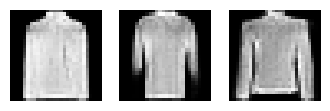

In [ ]:
# Generate 3 different clothing items
generate_and_show_images(generator, 3)

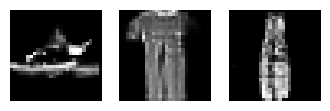

In [ ]:
# Generate 3 different clothing items
generate_and_show_images(generator, 3)

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

The above results indicate that increasing the training epoch to 200, has improved the image generation.

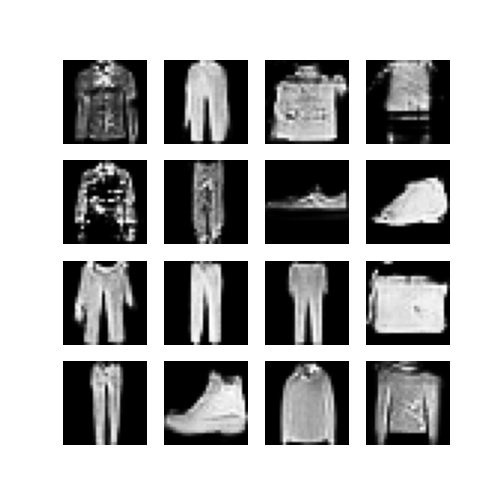

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-58-56bb6d34be2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-58-56bb6d34be2e>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



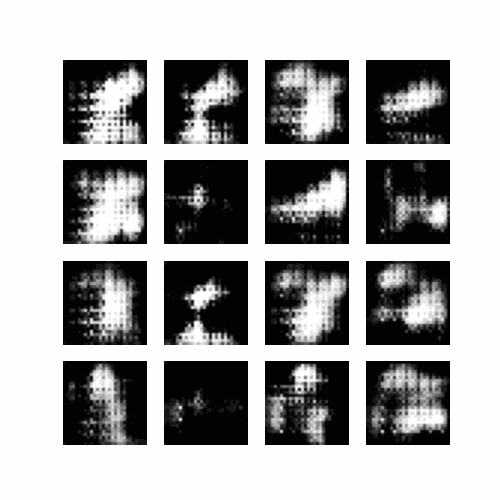

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

##Conclusion

The Deep Convolutional Generative Adversarial Network (DCGAN) technique was used to generate images. This network comprises two models—a generator and a discriminator—set up in an adversarial framework.

During the training process:
- The generator creates an image from random input.
- This generated image, along with real images from the ground-truth dataset, is fed into the discriminator.
- The discriminator evaluates both real and generated images, assigning probabilities between 0 and 1, where 1 indicates a real image and 0 indicates a fake.

This results in a dual feedback loop:

- The discriminator learns by comparing its predictions with the known ground truth.
- The generator and discriminator continuously refine their performance through adversarial training.

After training, Used the generator model to generate three distinct images of clothing.
